<table align="left" style="border-style: hidden" class="table"> <tr><td class="col-md-2"><img style="float" src="http://prob140.org/assets/icon256.png" alt="Prob140 Logo" style="width: 120px;"/></td><td><div align="left"><h3 style="margin-top: 0;">Probability for Data Science</h3><h4 style="margin-top: 20px;">UC Berkeley, Fall 2019</h4><p>Ani Adhikari and Jim Pitman</p>CC BY-NC 4.0</div></td></tr></table><!-- not in pdf -->

In [1]:
from prob140 import *
from datascience import *
import numpy as np
from scipy import stats
from scipy import special
from itertools import combinations

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Lab 6: Decisions Based on Ranks #

In Data 8 you developed ways to decide whether two numerical samples come from the same underlying distribution. One approach was to combine the two samples and observe that if the samples were drawn from the same distribution, then each one should look like random draws from the combined sample.

In this lab you will study a variation of this approach that is useful when you are trying to decide between the following hypotheses about one of the samples. 
- **Null**: The sample looks like a simple random sample drawn from the combined data.
- **Alternative**: The data in the sample are in general smaller than the data in the other sample.

Suppose there are $n$ elements in your sample and $m$ elements in the other sample. Let $N = n+m$ denote the size of the combined sample. The method is based on *ranking* all $N$ elements of the combined sample with the convention that Rank 1 is the smallest and Rank $N$ the largest. 

For now, set aside details such as how to rank elements that are equal. Focus on the main idea:
- If the data in your sample look like a simple random sample from the combined data, then the ranks in your sample should look like a simple random sample of size $n$ drawn from $\{1, 2, 3, \ldots, N\}$.
- If the data in your sample are in general smaller than the data in the other sample, then the ranks in your sample should in general be lower than a simple random sample of ranks.

So the method compares the ranks in your sample with a simple random sample drawn from the first $N$ integers. 

If it seems as though this throws away the data and just retains the ranks, that's true but not harmful for several reasons.
- If you are trying to decide between the two hypotheses stated above, then you care about whether elements are bigger or smaller than each other, but not on exactly how big they are; so ranks are all you need.
- The method is easy to use for small samples as well as large, and does not require assumptions about the distribution of the combined sample.
- The method works pretty well compared to methods that do depend on assumptions about the underlying distributions.
- Ranks are not affected by outliers.

Besides, sometimes all you have are ranks. For example, you may have a ranking of candidates for admission but no single numerical measure that leads to the ranks. You can use the methods of this lab to compare the ranks of two categories of applicants.

What you will learn about in this lab:
- Settings in which it makes more sense to use ranks than the original data
- How to use Python to rank data
- A useful statistic based on ranks
- How to find the exact distribution of the statistic when the sample size is small
- How to work with the normal curve in Python
- The normal approximation to the distribution of the statistic

## Instructions
Your labs have two components: a written portion and a portion that also involves code. Written work should be completed on paper, and coding questions should be done in the notebook. You are welcome to LaTeX your answers to the written portions, but staff will not be able to assist you with LaTeX related issues. It is your responsibility to ensure that both components of the lab are submitted completely and properly to Gradescope. Refer to the bottom of the notebook for submission instructions.

#newpage
## Part 1: Ranks ##
We will develop the method by revisiting Deflategate, a storm in the world of American football and familiar to us from Data 8.

Here are some extracts from the Data 8 textbook:

"On January 18, 2015, the Indianapolis Colts and the New England Patriots played the American Football Conference (AFC) championship game to determine which of those teams would play in the Super Bowl. After the game, there were allegations that the Patriots' footballs had not been inflated as much as the regulations required; they were softer. This could be an advantage, as softer balls might be easier to catch ...

At half-time, all the game balls were collected for inspection. Two officials, Clete Blakeman and Dyrol Prioleau, measured the pressure in each of the balls. 

Here are the data. Each row corresponds to one football. Pressure is measured in psi [pounds per square inch]. The Patriots ball that had been intercepted by the Colts was not inspected at half-time. Nor were most of the Colts' balls – the officials simply ran out of time and had to relinquish the balls for the start of second half play."

Each team had 12 footballs. Eleven of the Patriots' footballs were measured, and four of the Colts'.

In [2]:
football = Table.read_table('Lab06_data/deflategate.csv')

In [3]:
football.show()

Team,Blakeman,Prioleau
Patriots,11.5,11.8
Patriots,10.85,11.2
Patriots,11.15,11.5
Patriots,10.7,11
Patriots,11.1,11.45
Patriots,11.6,11.95
Patriots,11.85,12.3
Patriots,11.1,11.55
Patriots,10.95,11.35
Patriots,10.5,10.9


It is clear that the Patriots' footballs had less pressure than the Colts'. But that is not a fair comparison since the two sets of footballs started out at different pressures: all the Patriots' footballs at 12.5 psi and the Colts' at 13 psi, both levels allowed by NFL regulations. 

Pressure drops naturally during the game. The variable of interest, therefore, is the amount by which the pressure dropped. The Colts' allegation can be politely restated as saying that the drops in pressure among the Patriots' footballs were so large that something unusual had to have happened.

### 1a) Drop in Pressure ###
Based on each of the columns `Blakeman` and `Prioleau`, calculate the drop in pressure for each football. Start by creating an array of the 15 starting values of pressure. Remember that `np.ones(n)` evaluates to an array of $n$ 1's, and `np.append(array_1, array_2)` evaluates to an array that appends `array_2` to `array_1`. 

In [4]:
start = np.append(12.5* np.ones(11), 13 * np.ones(4))

blakeman_drops = start - football['Blakeman']
prioleau_drops = start - football['Prioleau']

Run the cell below and confirm a few of the drop values by mental math.

In [5]:
drops = football.drop(1, 2).with_columns(
    'Blakeman', blakeman_drops,
    'Prioleau', prioleau_drops
)

drops.show()

Team,Blakeman,Prioleau
Patriots,1,0.7
Patriots,1.65,1.3
Patriots,1.35,1
Patriots,1.8,1.5
Patriots,1.4,1.05
Patriots,0.9,0.55
Patriots,0.65,0.2
Patriots,1.4,0.95
Patriots,1.55,1.15
Patriots,2,1.6


### 1b) Ranking the Data ###
It does look as though the pressure drop among the Colts' footballs was less than that among the Patriots'. To examine this further, we have to first figure out how to deal with the fact that the two officials' measurements were different from each other.

Since we are just interested in the ordering of the drops and not their values, it's a good idea to look at ranks and see how the two officials' rankings compare.

The `stats` function `rankdata` takes a numerical array as its argument and returns the array of ranks.

In [6]:
data_1 = make_array(27, 32, 28, 35, 25)
stats.rankdata(data_1)

array([2., 4., 3., 5., 1.])

When we use rank-based methods we do have to face the issue of "ties," that is, data values that are equal. For what we are going to do in this lab, it doesn't matter how you rank tied values. We ask that you rank ties by using the `method = 'ordinal'` option of `rankdata`. It assigns distinct ranks to all the values, assigning consecutive ranks to equal values in the order in which they appear in the data.

In [7]:
data_2 = np.append(data_1, 32 * np.ones(3))
data_2, stats.rankdata(data_2, method = 'ordinal')

(array([27., 32., 28., 35., 25., 32., 32., 32.]),
 array([2, 4, 3, 8, 1, 5, 6, 7]))

Use `rankdata` with the `method = 'ordinal'` option to rank Blakeman's drop values, and, separately, Prioleau's drop values.

In [8]:
blakeman_ranks = stats.rankdata(drops['Blakeman'], method = 'ordinal')
prioleau_ranks = stats.rankdata(drops['Prioleau'], method = 'ordinal')

Look at the ranks below and do a quick mental check of a few of them for accuracy.

In [9]:
drops = drops.with_columns(
    'Blakeman Ranks', blakeman_ranks,
    'Prioleau Ranks', prioleau_ranks
)

In [10]:
drops.show()

Team,Blakeman,Prioleau,Blakeman Ranks,Prioleau Ranks
Patriots,1,0.7,7,5
Patriots,1.65,1.3,13,13
Patriots,1.35,1,8,9
Patriots,1.8,1.5,14,14
Patriots,1.4,1.05,9,10
Patriots,0.9,0.55,6,3
Patriots,0.65,0.2,5,2
Patriots,1.4,0.95,10,8
Patriots,1.55,1.15,11,11
Patriots,2,1.6,15,15


### 1c) Consistency of Ranks ###
In which columns is it easier to compare consistency and inconstency between the two officials: the ranks or the drop values? What consistencies and inconsistencies do you notice when you compare the ranks?

It is easier to compare the ranks since it gives a direct means of contextual comparison between the sets of data for each ref. It is interesting to note that the Colts balls are all at least below rank 8, which leaves the patriots to have the highest ranks in terms of the amount of psi dropped. One inconsistency though is that Blakemans measurements for the Colts football are all the lowest rank, 1-4, while for Blakeman some of the measurements are slightly higher which is interesting since they were supposedly measuring the same balls.

#newpage

## Part 2: Wilcoxon's Rank Sum Statistic ##

Is the difference due to chance? More precisely, the question is whether the Colts' ranks are like a simple random sample of all 15 ranks or whether the Colts' ranks are generally smaller than the Patriots'. If they are smaller, then it means that by comparison, the pressure in the Patriots' footballs dropped by more than can't be explained by random chance. That is what the Colts' were alleging. 

In fact, the Colts were alleging even more, which is that the increased drop was deliberate. We can't assess that. But we can see whether the the Colts' ranks are generally too low to be explained by chance.

It is now time to quantify "ranks are generally too low". We will do this by using the *[Wilcoxon](https://en.wikipedia.org/wiki/Frank_Wilcoxon) Rank Sum statistic*, which is just the sum of the Colts' ranks. A low rank sum corresponds to the Colts' ranks being "generally low". In general, the Wilcoxon rank sum statistic is the sum of the ranks of one of the two samples.

It is important to keep in mind that we are not interested in which of the Colts' footballs received which rank; we are just interested in the set of ranks received by those balls. That is, we are interested in an unordered sample of 4 out of the 15 ranks.

### 2a) Blakeman's Rank Sum ###
What is the rank sum statistic based on Blakeman's ranks? That is, what is the sum of the Colts' ranks as assigned by Blakeman?

The sum of the Colts' ranks as assigned by Blakeman is 10.

How many sets of four can be formed from among the numbers 1 through 15? Remember that `special.comb(n, k)` evaluates to ${n \choose k}$.

In [11]:
total_samples = special.comb(15,4)
total_samples

1365.0

What is the smallest possible sum that you can get from a subset of four numbers from chosen from the integers 1 through 15? How many subsets have this sum? 

The smallest possible sum you can get from a set of four numbers chose from 1-15 is (1+2+3+4) = 10, and 10 total subsets have values that sum up to 10.

Based on the value of Blakeman's rank sum, should you conclude that the Colts' ranks are like a random sample of four ranks? Explain briefly.


**Your answer here.**

### 2b) Prioleau's Rank Sum ###
Now turn to Prioleau's ranks.

In [12]:
prioleau = drops.select(0, 4)
prioleau.show()

Team,Prioleau Ranks
Patriots,5
Patriots,13
Patriots,9
Patriots,14
Patriots,10
Patriots,3
Patriots,2
Patriots,8
Patriots,11
Patriots,15


#### You can of course calculate Prioleau's rank sum mentally, but for further applications it is useful to be able to do this using Python.

Use `group` to find Prioleau's rank sum for both teams. Refer to the [Data 8 Python reference](http://data8.org/sp18/python-reference.html) if necessary. The table `both_sums` should contain both the rank sums, and `prioleau_colts_sum` should be the observed value of Prioleau's statistic.

In [13]:
def Aggregate_Score(x):
    return sum(x)
both_sums = drops.group(['Team'], Aggregate_Score).select(0,4)
prioleau_colts_sum = both_sums['Prioleau Ranks Aggregate_Score'].item(0)

both_sums

Team,Prioleau Ranks Aggregate_Score
Colts,18
Patriots,102


Use the cell below to show why the total of all the ranks is 120. Fill in the comment as an explanation, and then compute the sum **not by brute force but by using an appropriate formula that can easily be applied when the sample is larger.**

In [14]:
# The total of the ranks is the sum of all the ranks, from 1-15, where S(n) = (n*(n+1))/2, thus S(15) = 120

drops.group(['Prioleau Ranks', 'Blakeman Ranks']).sum()

/srv/app/venv/lib/python3.6/site-packages/datascience/tables.py:193: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


Prioleau Ranks,Blakeman Ranks,count
120,120,15


### 2c) All Possible Rank Sums ###
The `combinations` function of `itertools` has been imported and is used as below to display all the subsets of four out the 15 ranks. These are all the possible samples of ranks that the Colts' could have. Check that the table has the right number of rows.

In [15]:
population = np.arange(1, 16)

all_samples = Table().with_column(
    'Ranks', list(combinations(population, 4))
)

all_samples

Ranks
[1 2 3 4]
[1 2 3 5]
[1 2 3 6]
[1 2 3 7]
[1 2 3 8]
[1 2 3 9]
[ 1 2 3 10]
[ 1 2 3 11]
[ 1 2 3 12]
[ 1 2 3 13]


Construct an array `rank_sums` consisting of the sums of the ranks in all the samples, and augment the table `all_samples` with a column `Rank Sum` containing the rank sums.

In [16]:
rank_sums = []
for x in all_samples['Ranks']:
    rank_sums.append(sum(x))
rank_sums
all_samples = all_samples.with_columns('Rank Sums', rank_sums)

all_samples

Ranks,Rank Sums
[1 2 3 4],10
[1 2 3 5],11
[1 2 3 6],12
[1 2 3 7],13
[1 2 3 8],14
[1 2 3 9],15
[ 1 2 3 10],16
[ 1 2 3 11],17
[ 1 2 3 12],18
[ 1 2 3 13],19


### 2d) Probability Distribution of the Rank Sum ###
What is the smallest and largest the rank sum can be? You should not need to use `sort`.

In [17]:
smallest = 10
largest = 54

smallest, largest

(10, 54)

Draw a histogram of the rank sums, using bins of width 1 centered on each possible value of the rank sum. As this histogram is based on every possible sample, it displays the *sampling distribution* or equivalently the exact probability distribution of the rank sum statistic under the null hypothesis of random selection.

Note that you will need to offset your bins by 0.5 to ensure that the bars are centered properly.

The additional line of code plots the observed rank sum on the horizontal axis.

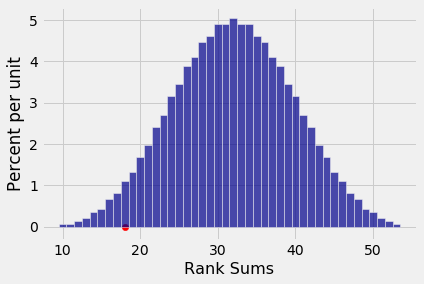

In [18]:
b = []
x = 9.5
while x < 54:
    b.append(x)
    x +=1
all_samples.hist('Rank Sums', bins = b)
plt.scatter(prioleau_colts_sum, 0, color='red', s=40);

### 2e) The Decision ###
Compute the $P$-value of the test. This is an exact $P$-value, not an empirical or numerical approximation.

Recall that the $P$-value is the probability, assuming the null hypothesis is true, of observing a statistic that is equal to the one in our sample or even more in the direction of the alternative.

In [19]:
sum(all_samples['Rank Sums'] <= 18)/len(all_samples['Rank Sums'])

0.03882783882783883

What is your decision, based on the test? Which of the two hypotheses do you think is better supported by the data?

Based on this test, the alternative hypothesis is better supported by the data since the P-value shows that if we assume the null hypothesis to be true, the probability of getting a sum of 18 or less is 0.0388 which is quite a low probability, thus rejecting the null and supporting the alternative.

#newpage

## Part 3: Normal Curves ##
The probability distribution of the rank sum statistic looks very much like the normal curve, but not exactly. For example, look at the peak of the curve. You will see two flat bits on either side. 

Still, the distribution doesn't look too far from normal, so it is worth reminding ourselves about the normal curve. This part of the lab takes you quickly through some code that you can use to display normal curves and areas under them, and also to find numerical values of the areas.

### 3a) Plotting the Curve ###
The equation of this curve is one of the greatest hits of probability theory, mathematics, and statistics. Here it is, though you will not need it for the lab. Of course we will have a lot to do with it later in Prob 140.

The parameters of the curve are a "center" $\mu$ that can be any number, and a "spread" $\sigma$ that is a positive number. The equation is

$$
f(x) ~ = ~ \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}, ~~~~~~~ -\infty < x < \infty
$$

The relation of $\mu$ and $\sigma$ to the expectations and variances that we have been studying in class will become more evident as you go through the lab.

To plot the curve, use the `prob140` function `Plot_norm` with three arguments:
- the interval of values of $x$ over which to plot the curve
- the "center" of the curve, which is $\mu$
- the "spread" of the curve, which is $\sigma$

The curve corresponding to $\mu = 0$ and $\sigma = 1$ is called the *standard normal curve*.

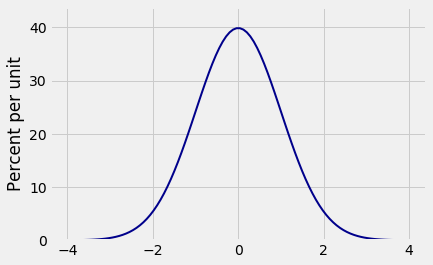

In [20]:
Plot_norm((-4, 4), 0, 1)

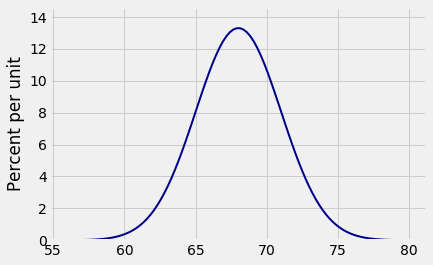

In [21]:
Plot_norm((56, 80), 68, 3)

You can see that the two are just the same curve, apart from labels on the axes. 

We will prove later in the term that the total area under the normal curve is 100%. You can therefore think of the curve as a continuous approximation to a discrete histogram.

### 3b) Areas Under the Curve ###
As you know, for a discrete random variable the cumulative distribution function (cdf) at a point is the area under the probability histogram to the left of that point. The cdf of the normal curve is defined analogously.

The gold area below is the value of the cdf of the standard normal curve at the point $x = 2$. Notice the use of `right_end = 2` to color the area; when the left end is not specified, it is assumed to be the leftmost value on the horizontal axis.

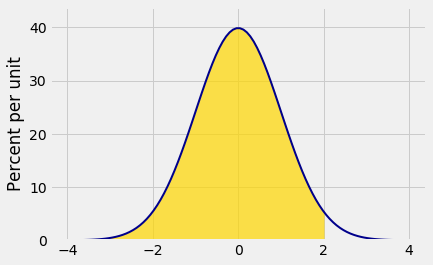

In [22]:
Plot_norm((-4, 4), 0, 1, right_end = 2)

The numerical value of the area is found by `stats.norm.cdf` with the arguments $x$, $\mu$, and $\sigma$.

In [23]:
stats.norm.cdf(2, 0, 1)

0.9772498680518208

Find the numerical value of the area below.

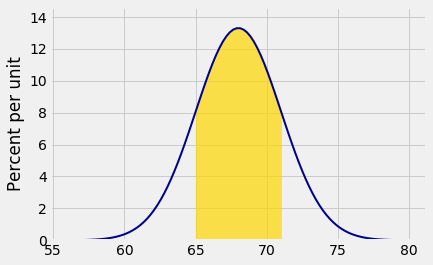

In [24]:
Plot_norm((56, 80), 68, 3, left_end = 65, right_end = 71)

In [25]:
stats.norm.cdf(71, 68,3) - stats.norm.cdf(65, 68, 3)

0.6826894921370859

#newpage

## Part 4: Normal Approximation ##
To use a normal curve to approximate a distribution, you must first identify the two parameters of the curve. For reasons that are not surprising and will become precise later in the course, the right parameters are the expectation and SD of the distribution being approximated.

Let's find the normal curve that approximates the distribution of the rank sum statistic in Part 2. Why approximate a distribution we already know exactly? The answer is that we will need the method of approximation when the sample sizes are too large for us to be able to enumerate all possible samples. Finding the approximation in a case where we know the exact answer helps us see that the approximation is good.

### 4a) Expectation and SD Under the Null ###
Under the null hypothesis of random selection, the distribution of our rank sum statistic is the distribution of the sum of a simple random sample of size 4 from the population of integers 1 through 15.

In general, let $W$ be the sum of  $n$ ranks drawn at random without replacement from the integers 1 through $N$.

Refer to [Sections 12.1](http://prob140.org/textbook/Chapter_12/01_Definition.html) and [13.3](http://prob140.org/textbook/Chapter_13/03_Sums_of_Simple_Random_Samples.html) of the textbook for the formulas that you need in order to define the functions below. 

Define a function `ev_ranksum` that takes $n$ and $N$ as its arguments and returns $E(W)$. **Do not** use arrays or `np.average` in your definition. Use the formulas derived in class.

In [26]:
def ev_ranksum(n, N):
    return n*(N+1)/2

null_expectation = ev_ranksum(4, 15)
null_expectation

32.0

Now define a function `sd_ranksum` that takes $n$ and $N$ as arguments and returns $SD(W)$. **Do not** use arrays or `np.std` in your definition.

In [27]:
def sd_ranksum(n, N):
    return np.sqrt((n*(N**2-1)/12)*(N-n)/(N-1))

null_sd = sd_ranksum(4, 15)
null_sd

7.659416862050705

To check your numerical answers, remember that you enumerated every possible sample and hence every possible rank sum. Run the cell below and confirm that its output is the same as the values returned by your functions.

In [28]:
np.average(rank_sums), np.std(rank_sums)

(32.0, 7.659416862050705)

### 4b) Superposing the Approximating Curve ###
Re-use both lines of code in the last cell of 2d, and use Plot_norm appropriately to superpose the approximating normal curve over the histogram. Ignore the last line in the cell. It just sets a vertical scale so you can see all the different aspects of the figure.

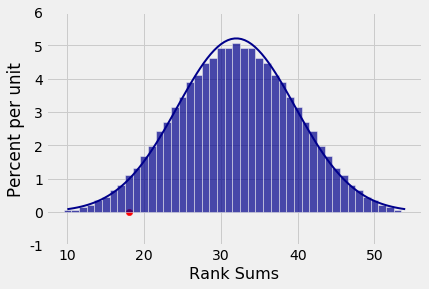

In [29]:
b = []
x = 9.5
while x < 54:
    b.append(x)
    x +=1
all_samples.hist('Rank Sums', bins = b)
plt.scatter(prioleau_colts_sum, 0, color='red', s=40);

Plot_norm((10,54), ev_ranksum(4,15), sd_ranksum(4,15))
plt.ylim(-0.01, 0.06);

You can see that the curve overestimates near the center, then underestimates on both sides, and then overestimates again in the tails. But it's not bad. The approximation typically improves when the sample sizes get larger.

#newpage

## Part 5: Continuity Correction ##

In **2e** you found the exact $P$-value of the test of whether the four Colts ranks are too low to resemble a random sample of ranks. The graph above indicates that it should be possible to find an approximation to that chance using the normal curve.

### 5a) Normal Approximation, First Attempt ###
Use `stats.norm.cdf` to approximate the $P$-value. You will need quantities you defined in Part 4 as well as `prioleau_colts_sum` from Part 2.

In [30]:
stats.norm.cdf(18, ev_ranksum(4,15), sd_ranksum(4,15))

0.03378863152793527

Notice that the answer isn't quite what you got in **2e**. A common recommendation for small samples is that you either get an exact $P$-value as you did in Part 2 or use the normal approximation *with continuity correction*. The correction takes into account the fact that you are using a continuous curve to approximate a histogram consisting of rectangular bars.

### 5b) Continuity Correction ###
The correction is easier to see in the context of the binomial $(100, 1/2)$ histogram, that is, the distribution of the number of heads in 100 tosses of a coin. 

Look up [Section 13.2](http://prob140.org/textbook/Chapter_13/02_Sums_of_IID_Samples.html) of the textbook for the expectation and SD of the number of heads. Enter them below to draw the normal curve superposed on the binomial histogram.

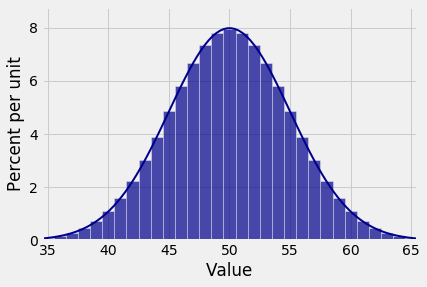

In [34]:
b100 = stats.binom.pmf(np.arange(101), 100, 0.5)
coins100 = Table().values(range(101)).probabilities(b100)

Plot(coins100, edges=True)
Plot_norm((34.5, 65.5), 50, 5)
plt.xlim(34.5, 65.5);

The normal approximation is excellent and doesn't systematically overestimate or underestimate. The exact chances, of course are the areas of the bars of the histogram.

Let $X$ be the number of heads in 100 tosses. The blue area below is the exact value of $P(45 \le X \le 55)$.

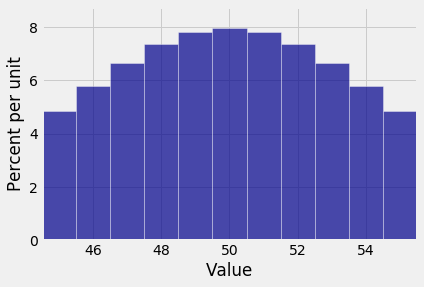

In [35]:
Plot(coins100, edges=True)
plt.xlim(44.5, 55.5);

Find the numerical value of $P(45 \le X \le 55)$.

In [38]:
sum(stats.binom.pmf(np.arange(45,56), 100, 0.5))

0.728746975926143

Here is the area again, but this time we have superposed the normal curve and colored the area under the curve between 45 and 55. The color is gold, as you can see between the bars and the curve. The purplish shade is due to the overlap between the gold and the blue.

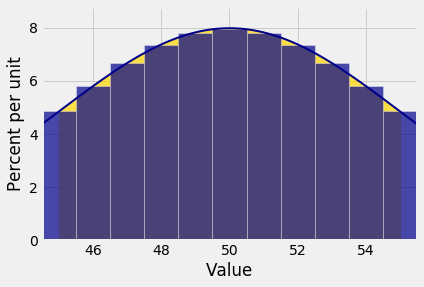

In [39]:
Plot(coins100, edges=True)
Plot_norm((43.5, 56.5), 50, 5, left_end=45, right_end=55)
plt.xlim(44.5, 55.5);

Is the colored area under the curve (purple plus gold) a good approximation to $P(45 \le X \le 55)$? If not, what is the main problem with it?

It is not the best approximation since it is missing half of the 45 bin and half of the 55 bin

Correct the problem, that is, make the *continuity correction*, by completing the cell below. Make sure to only edit `left_end` and `right_end`.

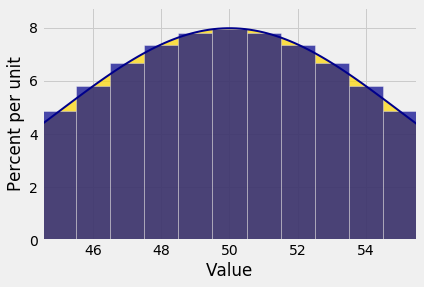

In [40]:
Plot(coins100, edges=True)
Plot_norm((43.5, 56.5), 50, 5, left_end = 44.5, right_end = 55.5)
plt.xlim(44.5, 55.5);

Use `stats.norm.cdf` to find the colored area under the normal curve above, and compare with the exact answer you got earlier in this exercise.

In [52]:
stats.norm.cdf(55.5, 50, 5) - stats.norm.cdf(44.5,50,5)

0.7286678781072347

### 5c) Normal Approximation with Continuity Correction ###
Now revisit **5a** and **2e**, and use the continuity correction in the normal approximation to the $P$-value. Compare with the exact value.

In [53]:
stats.norm.cdf(prioleau_colts_sum+0.5, ev_ranksum(4,15), sd_ranksum(4,15))

0.0389893672505451

Look again at the graph in **4b**. The normal curve won't do a good job at approximating probabilities of intervals around the center, with or without continuity correction. Indeed, you can easily find intervals where using the continuity correction is worse than not using it. 

We have the exact distribution of the statistic, so we should just use that. The normal approximation is better when the samples are large, which is also when it is intractable to find the exact distribution.

#newpage

## Part 6: Large Sample Analysis ##
The beauty of the rank-based method is that it extends easily to large samples. Here is a sample of the ages of 231 men and women, part of a larger data set that included other attributes as well. The code for gender was 0 for female and 1 for male; no other categories were recorded. The ages include fractional parts of a year, which is why the decimals aren't pretty.

In [54]:
ages = Table.read_table('Lab06_data/ages.csv')

In [55]:
ages

Gender,Age
0,41.7623
0,29.6858
0,34.5601
0,45.4809
0,35.5164
0,45.2568
0,49.4317
0,42.9481
0,46.4235
0,45.6257


Use `group` to count the number of people of each gender.

In [56]:
ages.group('Gender')

Gender,count
0,177
1,54


Using the `group` option with `hist` results in overlaid histograms of the two groups. It looks as though the men are a little younger than the women, on the whole, but it's hard to say. 

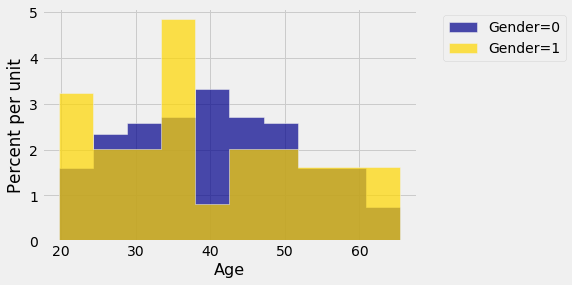

In [57]:
ages.hist('Age', group='Gender')

Use the Wilcoxon Rank Sum test to see whether the ages of the men look like random draws from the combined sample, or whether the men are younger.

Start by ranking all the ages, and remember `method='ordinal'`. In the next line, create a table consisting of two columns:

- the `Gender` column of `ages` 
- a column called `Age Rank` containing the ranks of the ages

In [62]:
age_ranks = stats.rankdata(ages['Age'], method = 'ordinal')
ranked = ages.with_column('Age Rank', age_ranks)
ranked

Gender,Age,Age Rank
0,41.7623,130
0,29.6858,49
0,34.5601,80
0,45.4809,152
0,35.5164,90
0,45.2568,151
0,49.4317,177
0,42.9481,136
0,46.4235,158
0,45.6257,154


Find the rank sum of the men. It's fine to display it as part of a table.

In [67]:
ranked.group('Gender', sum)

Gender,Age sum,Age Rank sum
0,7176.3,20815
1,2140.01,5981


Let $W$ be the rank sum statistic. Under the null hypothesis of random selection, find $E(W)$ and $SD(W)$ by using the functions you defined in Part 4.

In [68]:
exp_W = ev_ranksum(54, 231)
sd_W = sd_ranksum(54, 231)

exp_W, sd_W

(6264.0, 429.86974771435126)

Based on these numbers and the observed value of the statistic, can you decide whether you think the ranks of the men look like a simple random sample of all 231 ranks?

I think that based on the expected value and standard deviation found above, the ranks of the men do indeed look like a simple random sample of 231 ranks since the actual Age Rank sum is close to the expected value calculated above(within 1 SD).

Confirm your conclusion by finding a normal approximation to the $P$-value. Continuity correction won't make much difference.

In [69]:
stats.norm.cdf(5981, exp_W, sd_W)

0.2551601762650195

## Conclusion ##
What you have learned:
- A rank-based method for inference
- How to enumerate all possible simple random samples to get the sampling distribution of a statistic
- Applications of expectation and SD formulas derived in class, for comparing two samples
- Mechanics of the normal approximation to discrete distributions

## Submission Instructions ##

Many assignments throughout the course will have a written portion and a code portion. Please follow the directions below to properly submit both portions.

### Written Portion ###
*  Scan all the pages into a PDF. You can use any scanner or a phone using an application. Please **DO NOT** simply take pictures using your phone. 
* Please start a new page for each question. If you have already written multiple questions on the same page, you can crop the image or fold your page over (the old-fashioned way). This helps expedite grading.
* It is your responsibility to check that all the work on all the scanned pages is legible.

### Code Portion ###
* Save your notebook using File > Save and Checkpoint.
* Generate a PDF file using File > Download as > PDF via LaTeX. This might take a few seconds and will automatically download a PDF version of this notebook.
    * If you have issues, please make a follow-up post on the general Lab 6 Piazza thread.
    
### Submitting ###
* Combine the PDFs from the written and code portions into one PDF.  [Here](https://smallpdf.com/merge-pdf) is a useful tool for doing so. 
* Submit the assignment to Lab 6 on Gradescope. 
* **Make sure to assign each page of your pdf to the correct question.**
* **It is your responsibility to verify that all of your work shows up in your final PDF submission.**


### **We will not grade assignments which do not have pages selected for each question.** 